In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit

## Identify Recessions Periods

In [220]:
start = '1995-01-01'

In [221]:
today = datetime.today().strftime("%Y-%m-%d")
today

'2020-04-09'

In [222]:
url = 'https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=1168&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=SP500&scale=left&cosd='+start+'&coed='+today+'&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=3&lw=2&ost=-99999&oet=99999&mma=0&fml=a&fq=Daily%2C%20Close&fam=avg&fgst=lin&fgsnd='+start+'&line_index=1&transformation=lin&vintage_date='+today+'&revision_date='+today+'&nd='+start
SP500 = pd.read_csv(url)
SP500['DATE'] = pd.to_datetime(SP500['DATE'])

SP500 = SP500[SP500['SP500'] != '.']
SP500['SP500'] = SP500['SP500'].apply(float)

temp = pd.read_csv("S&P500.csv")
temp['Date'] = pd.to_datetime(temp['Date'])
temp.sort_values("Date",inplace=True)
temp = temp[['Date', 'Adj Close']]

temp = temp[temp['Date'] < SP500.loc[0, 'DATE']].reset_index()
del temp['index']
SP500.columns = temp.columns

df = pd.concat([temp, SP500])
df = df[df['Date'] >= pd.to_datetime(start)].reset_index()
del df['index']
df.sort_values("Date",inplace=True)
df.tail()

,Date,Adj Close
6357,2020-04-02,2526.90
6358,2020-04-03,2488.65
6359,2020-04-06,2663.68
6360,2020-04-07,2659.41
6361,2020-04-08,2749.98


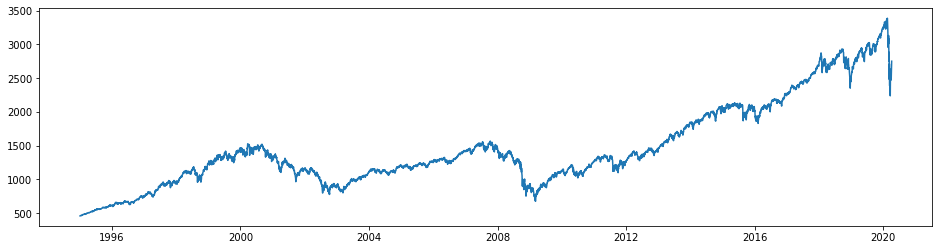

In [167]:
plt.figure(figsize=(16,4))
plt.plot(df['Date'],df['Adj Close'])

In [165]:
df

,Date,Adj Close
0,1995-01-03,459.109985
1,1995-01-04,460.709991
2,1995-01-05,460.339996
3,1995-01-06,460.679993
4,1995-01-09,460.829987
...,...,...
6357,2020-04-02,2526.900000
6358,2020-04-03,2488.650000
6359,2020-04-06,2663.680000
6360,2020-04-07,2659.410000


In [181]:
recession_rate = 0.20
def recession(df, recession_rate, min_days = 90):
    recessions = list()
    days = df.shape[0]
    for i in range(0,days):
        for j in range(i+1,days):
            if df.loc[j,'Adj Close'] <= df.loc[i,'Adj Close']*(1-recession_rate):
                temp = df.loc[i:j,:]
                max_index = temp[temp['Adj Close'] == temp['Adj Close'].max()].index[-1]
                if ((df.loc[max_index,'Date'],df.loc[j,'Date']) not in recessions):
                    recessions.append((df.loc[max_index,'Date'],df.loc[j,'Date']))
                    if max_index>j:
                        raise ValueError
                break
    recessions = sorted(recessions, key = lambda x: x[0])
    
    rec = list()
    for i in range(len(recessions)-1):
        if len(rec)==0:
            if recessions[i][1] >= recessions[i+1][0]:
                if recessions[i][1]<=recessions[i+1][1]:
                    rec.append((recessions[i][0],recessions[i+1][1]))
                elif recessions[i][1]>=recessions[i+1][1]:
                    rec.append((recessions[i][0],recessions[i][1]))
        else:
            if recessions[i][0] <= rec[-1][1]:
                if rec[-1][1]<=recessions[i+1][1]:
                    rec[-1]=(rec[-1][0], recessions[i][1])
            else:
                rec.append(recessions[i])
                
    rec_periods = list()
    timediff = pd.Timedelta(days=120)
    for i in range(len(rec)):
        if i == 0:
            rec_periods.append(rec[0])
        elif rec[i][0] - rec_periods[-1][1] <= timediff:
            rec_periods[-1] = (rec_periods[-1][0],rec[i][1])
        else:
            rec_periods.append(rec[i])
    return rec_periods
rec_periods = recession(df, recession_rate)
rec_periods

[(Timestamp('2000-03-24 00:00:00'), Timestamp('2002-10-09 00:00:00')),
 (Timestamp('2007-10-09 00:00:00'), Timestamp('2009-03-05 00:00:00')),
 (Timestamp('2020-02-19 00:00:00'), Timestamp('2020-03-23 00:00:00'))]

Text(0, 0.5, 'S&P 500 Index')

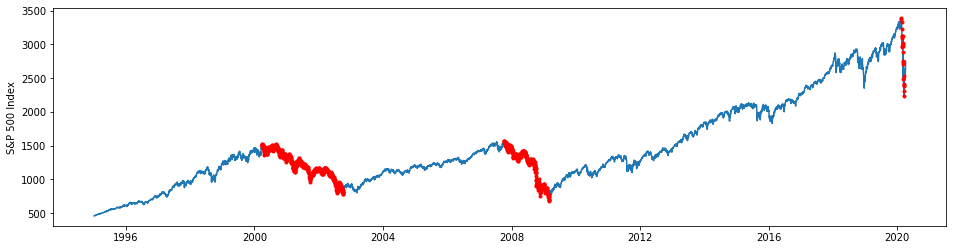

In [182]:
rec_index = list()
for (x, y) in rec_periods:
    rec_index.extend([z for z in range(df[df['Date'] == x].index[0],df[df['Date'] == y].index[0]+1)])
plt.figure(figsize=(16,4))
plt.plot(df['Date'],df['Adj Close'], marker='o', markerfacecolor='r',markeredgecolor='r', markersize=3 ,markevery=rec_index)
plt.ylabel('S&P 500 Index')

Text(0, 0.5, 'VIX Index')

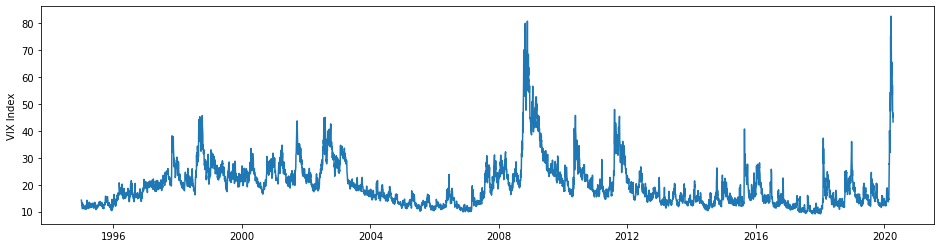

In [183]:
VIX_before2004 = pd.read_excel('http://www.cboe.com/publish/scheduledtask/mktdata/datahouse/vixarchive.xls',header = 1)
VIX_after2004 = pd.read_csv('http://www.cboe.com/publish/scheduledtask/mktdata/datahouse/vixcurrent.csv', header = 1)
VIX = pd.concat([VIX_before2004, VIX_after2004]).reset_index()
del VIX['index']
VIX = VIX[['Date', 'VIX Close']]
VIX['Date'] = pd.to_datetime(VIX['Date'])
VIX = VIX[VIX['Date'] >= df.loc[0, 'Date']]

plt.figure(figsize=(16,4))
plt.plot(VIX['Date'],VIX['VIX Close'])
plt.ylabel('VIX Index')

Text(0, 0.5, 'SMA_3 of VIX index')

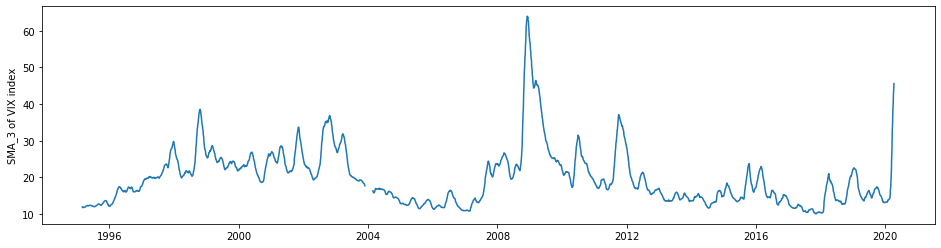

In [215]:
VIX['SMA'] = VIX.loc[:,'VIX Close'].rolling(window=40).mean()

plt.figure(figsize=(16,4))
plt.plot(VIX['Date'],VIX['SMA'])
plt.ylabel('SMA_3 of VIX index')

In [207]:
def VIX_recovery(start, end, VIX):
    
    vix0 = VIX[VIX['Date'] == start].index[0]
    for i in range(vix0, VIX.shape[0]):
        if VIX.loc[i, 'SMA'] <= VIX.loc[vix0, 'SMA'] and VIX.loc[i, 'Date'] > end:
            return((start, VIX.loc[i, 'Date']))

reccessions = list()
for i in range(len(rec_periods)):
    reccessions.append(VIX_recovery(rec_periods[i][0], rec_periods[i][1], VIX))
reccessions = [x for x in reccessions if x != None]
reccessions

[(Timestamp('2000-03-24 00:00:00'), Timestamp('2003-05-22 00:00:00')),
 (Timestamp('2007-10-09 00:00:00'), Timestamp('2009-12-29 00:00:00'))]

Text(0, 0.5, 'S&P500 Index')

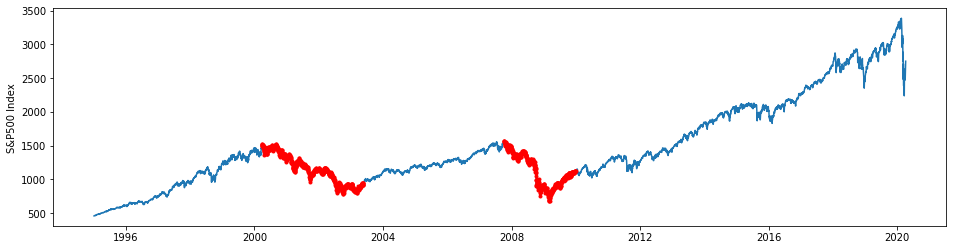

In [223]:
rec_index = list()
for (x, y) in reccessions:
    rec_index.extend([z for z in range(df[df['Date'] == x].index[0],df[df['Date'] == y].index[0]+1)])
    
plt.figure(figsize=(16,4))
plt.plot(df['Date'],df['Adj Close'], marker='o', markerfacecolor='r',markeredgecolor='r', markersize=3 ,markevery=rec_index)
plt.ylabel('S&P500 Index')

# plt.xlim(pd.to_datetime('2020-01-01'), pd.to_datetime(today))

## Rolling Validation

In [224]:
industry = r'Consumer_Discretionary'
df = pd.read_csv(industry+r'_all_companies.csv')
#delete wrong columns
for column in ['Unnamed: 0','return3','return5','return10','signal3','signal5','signal10']:
    del df[column]
df['Dates'] =  pd.to_datetime(df['Dates'],format='%Y-%m-%d')
df.sort_values("Dates",inplace=True)

In [225]:
df['intraday_return'] = df['PX_LAST'] / df['PX_OPEN'] - 1   # calculate intra-day return

In [226]:
def feature_selection(X, Y, m = 3, n_estimators=10):
    '''
    This function is used to select the 30 most important simgle or complex trading signals
    '''
    
    # X is the independant variables of train data
    # Y is the dependant variables of train data
    # m-day return
    # n_estimators is the parameter of RF model
       
    x_train = X.copy()
    y_train = Y.copy()
    
    ####################################################  select top10 simple rules
    model = RandomForestClassifier(n_estimators)
    model.fit(x_train,y_train['signal'+str(m)])
    importances = model.feature_importances_
    indices = np.argsort(importances)
    feat_labels = x_train.columns
    top10 = [feat_labels[indices[i]] for i in range(x_train.shape[1])][-10:]

    #################################################### construct 2-way rules
    for i in range(9):
        for j in range(10):
            x_train[top10[i] + '+' + top10[j]] = \
                np.array([1 if x+y>0 else -1 if x+y<0 else 0 for (x, y) in zip(x_train[top10[i]], x_train[top10[j]])]) 
            
    #################################################### construct 3-way rules
    three_way_columns = []
    for i in range(8):
        for j in range(i+1, 9):
            for k in range(j+1, 10):
                x_train[top10[i] + '+' + top10[j] + '+' + top10[k]] = \
                np.array([1 if x+y+z>0 else -1 if x+y+z<0 else 0 for (x, y, z) in zip(x_train[top10[i]], x_train[top10[j]], x_train[top10[k]])]) 

    #################################################### select top20 rules       
    model2 = RandomForestClassifier(n_estimators)
    model2.fit(x_train, y_train['signal'+str(m)])
    importances2 = model2.feature_importances_
    indices2 = np.argsort(importances2)
    feat_labels = x_train.columns
    top20 = [feat_labels[indices2[i]] for i in range(x_train.shape[1])][-20:]
    
    return x_train[top20]


In [227]:
def feature_combination(df, feature_list):
    # feature_list: the selected single and complex trading rules that needs to be generated in the test set
    
    temp = df.copy()
    for x in feature_list:
        features = x.split('+')
        if len(features) == 2:
            temp[x] = np.array([1 if x+y>0 else -1 if x+y<0 else 0 for (x, y) in zip(temp[features[0]], temp[features[1]])])
        if len(features) == 3:
            temp[x] = np.array([1 if x+y+z>0 else -1 if x+y+z<0 else 0 for (x, y, z) in zip(temp[features[0]], temp[features[1]], temp[features[2]])])
    temp = temp[feature_list]
    return temp

In [306]:
def Rolling_model(data, valid = True, test = False, test_para = 10, n_splits = 5, th = 0.0067, m = 3, n = 200, k = 22, parameters=None):

    # n_splits is the number of folds when spliting train set and test set
    # th is the thershold return rate used to generate trading signals
    # n days rolling windows and refit the model every K days because the portfolio is rebalanced
    # m-days return

    df = data.copy()

    X = df['Dates'].unique()
    N = len(X) 
    df['return'+str(m)] = df['intraday_return'].shift(-m)
    df = df.dropna()
    df['signal'+str(m)] = np.where(df['return'+str(m)] > th, 1 ,np.where(df['return'+str(m)] < -th, -1, 0))            

    if valid == True:
        N_valid = 0
        validation_performance = np.zeros(len(parameters))
        
        step = 0

        for i in range(0,N-(n+k),k):
            print(str(step)+ ' of '+ str(int((N-(n+k))/k)))
            step = step + 1
            train_data = X[i:i+n]
            tscv = TimeSeriesSplit(max_train_size=None, n_splits = n_splits)

            for train_index,valid_index in tscv.split(train_data):
                train_dates = pd.to_datetime(train_data[train_index])
                f = lambda x: True if x in train_dates else False
                train = df[df['Dates'].apply(f)]
                x_train = train.iloc[:,6:-3]
                y_train = train.iloc[:,-2:]

                #The first m days in validation set should be blocked
                #At each fold, we only use the t = m+1 day as validation data.
                valid_dates = pd.to_datetime(train_data[valid_index][m])
                valid = df[df['Dates'] == valid_dates]
                x_valid = valid.iloc[:,6:-3]
                y_valid = valid.iloc[:,-2:]
                N_valid += len(y_valid)

                #set the random forest
                for j in range(len(parameters)):
                    x_train = feature_selection(X = x_train, Y = y_train, m = m, n_estimators = parameters[j])
                    x_valid = feature_selection(X = x_valid, Y = y_valid, m = m, n_estimators = parameters[j])
                    model = RandomForestClassifier(n_estimators=parameters[j])
                    model.fit(x_train,y_train['signal'+str(m)])
                    y_pred_val = model.predict(x_valid)
                    validation_performance[j] += np.sum(y_pred_val == y_valid['signal'+str(m)])

            print('N_valid: ',N_valid, ', validation_performance: ', validation_performance)
        return N_valid, validation_performance

    if test == True and test_para != None:
        test_performance = 0
        #real value for test set
        y_real = np.array([],dtype='int')
        y_pred = np.array([],dtype='int')

        step = 0
        for i in range(0,N-(n+k),k):
            print(str(step)+ ' of '+ str(int((N-(n+k))/k)))
            step = step + 1
            
            y_real = np.concatenate((y_real,np.array(df[df['Dates'] == X[i+n+m]]['signal'+str(m)])))

            train_dates = pd.to_datetime(X[i:i+n])
            f = lambda x: True if x in train_dates else False
            train = df[df['Dates'].apply(f)]
            x_train = train.iloc[:,6:-3]
            y_train = train.iloc[:,-2:]
            
            x_train = feature_selection(X = x_train, Y = y_train, m = m, n_estimators = test_para)

            model = RandomForestClassifier(n_estimators = test_para)
            model.fit(x_train,y_train['signal'+str(m)])

            test_data = df[df['Dates'] == X[i+n+m]]
            x_test = test_data.iloc[:,6:-3]
            y_test = test_data.iloc[:,-2:]
            
            x_test = feature_combination(x_test, list(x_train.columns))
            
            prediction = model.predict(x_test)
            y_pred = np.concatenate((y_pred, np.array(prediction)))

        return y_real, y_pred

## Validation and test in the recession periods

In [288]:
def select_recession(n, df, reccessions):
    start = reccessions[n][0]
    end = reccessions[n][1]
    df1 = df.copy()
    df1 = df1[df1['Dates'] >= start]
    df1 = df1[df1['Dates'] <= end]
    return df1

In [289]:
def set_th(th, df, m):
    # m-day return
    df['signal'+str(m)] = np.where(df['intraday_return'] > th, 1 ,np.where(df['intraday_return'] < -th, -1, 0))
    print('When the threshold is '+str(th)+':')
    print('signal'+str(m)+'\n', df['signal3'].value_counts()/df.shape[0])

In [290]:
df1 = select_recession(1, df, reccessions)
set_th(0.02, df1, m = 3)

When the threshold is 0.02:
signal3
  0    0.510572
-1    0.247741
 1    0.241687
Name: signal3, dtype: float64


In [291]:
df2 = select_recession(0, df, reccessions)
set_th(0.02, df2, m = 3)

When the threshold is 0.02:
signal3
  0    0.608406
 1    0.205710
-1    0.185883
Name: signal3, dtype: float64


0 of 1
N_valid:  973 , validation_performance:  [532. 577. 565. 573. 578.]
1 of 1
N_valid:  1954 , validation_performance:  [ 986. 1064. 1054. 1069. 1096.]


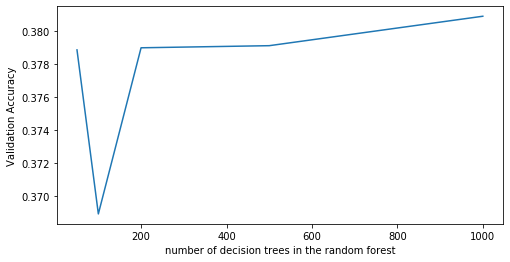

In [314]:
'''
the tunning parameter is n_estimators: 
Generally speaking, n_estimators is too small, which is easy to underfit. If n_estimators is too large, 
the amount of calculation will be too large, and after n_estimators reaches a certain number, 
increasing the model gain obtained by n_estimators will be small, so generally choose a moderate value. The default is 100.
'''
parameters = [50, 100, 200, 500, 1000]

def validation_performance(df, parameters, th, plot = True):
    N_valid, validation_performance = Rolling_model(df, valid = True, test = False, test_para = 10, th = th, k= 132, parameters = parameters)
    n_estimator = dict()
    for i in range(len(parameters)):
        n_estimator[parameters[i]] =  validation_performance[i]/N_valid
    
    if plot == True:
        plt.figure(figsize=(8,4))
        plt.plot(list(n_estimators.keys()),list(n_estimators.values()))
        plt.xlabel("number of decision trees in the random forest") 
        plt.ylabel("Validation Accuracy")
    
    return n_estimator

vp1 = validation_performance(df1, parameters, th = 0.02)

#### From the graph we can see that when the number of trees exceed 200, the test accuracy increased slowly. So 200 is the optimal value.

In [315]:
def test_performance(df, test_para, th):
    y_real, y_pred = Rolling_model(df1, valid = False, test = True, test_para = test_para, th = th, k = 132)
    test_accuracy = np.sum(y_real == y_pred)/len(y_real)
    return(test_accuracy)

test_performance(df1, test_para = 200, th = 0.02)

0 of 1
1 of 1


0.4607594936708861

In [316]:
test_performance(df2, test_para = 200, th = 0.02)

0 of 1
1 of 1


0.46582278481012657